# Litteraturbanken Author 
version 1.20 -  added link json 

* this [notebook](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb)
  * video Swedish
* [Wikidata:WikiProject_Sweden/The_Swedish_Literature_bank](https://www.wikidata.org/wiki/Wikidata:WikiProject_Sweden/The_Swedish_Literature_bank)

#### Other sources we sync
* [Arken](https://github.com/salgo60/open-data-examples/blob/master/Arken.ipynb) 
  * WD [Property:P8899](https://www.wikidata.org/wiki/Property:P8899) 
* [Kulturpersoner Uppsalakyrkogård](https://github.com/salgo60/open-data-examples/blob/master/Check%20WD%20kulturpersoner%20uppsalakyrkogardar.ipynb)
* [Litteraturbanken](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb) 
  * WD property [P5101](https://www.wikidata.org/wiki/Property_talk:P5101) [P5123](https://www.wikidata.org/wiki/Property_talk:P5123)
* [Nobelprize.org](https://github.com/salgo60/open-data-examples/blob/master/Nobel%20API.ipynb)
  * WD [property 8024](https://www.wikidata.org/wiki/Property:P8024)
* [SBL](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb) 
  * WD [property 3217](https://www.wikidata.org/wiki/Property:P3217) 
* [SKBL](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)
  * WD [property 4963](https://www.wikidata.org/wiki/Property:P4963)
* [Svenska Akademien](https://github.com/salgo60/open-data-examples/blob/master/Svenska%20Akademien.ipynb) 
  * WD [property 5325](https://www.wikidata.org/wiki/Property:P5325) 

#### Misc
* [T238932 API Litteraturbanken]([https://phabricator.wikimedia.org/T238932)
  * good API documention has not been found
  * GITHUB [spraakbanken/littb-frontend](https://github.com/spraakbanken/littb-frontend)
      * Question 
        * ~~how to see [JSON for a record 23](https://github.com/spraakbanken/littb-frontend/issues/23)~~
        * ~~[feedback data 24](https://github.com/spraakbanken/littb-frontend/issues/24)~~  
          * question if they will have [Persistent Litteraturbanken place id](https://github.com/spraakbanken/littb-frontend/issues/24#issuecomment-711140342)
  * API [get_authors](https://litteraturbanken.se/api/get_authors)
  * [url_list](https://litteraturbanken.se/api/url_list)
  * [API List all 0-10 include](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10&include=authors,forfattare,lbworkid,titlepath,title,librisid,mediatype,main_author.author_id)
    * [List all 0-10](https://litteraturbanken.se/api/list_all/etext,faksimil,pdf?from=0&to=10)
  * Wikidata 
    * property [P5101](https://www.wikidata.org/wiki/Property:P5101)
    * [other properties](https://w.wiki/eck) on the same object as Litterturbanken Author
* [Wikidata properties also available](https://w.wiki/eck) when we have P5101

**The objective** 
1. Find all Litteraturbanken Author objects that has Show True
1. Try to match Wikidata or create a new object for as many authors in Litteraturbanken as possible
  1. lesson learned not all authors are identified by Litteraturbanken --> maybe we should not create everyone in Wikidata or is Wikidata a good place to find relations e.g. [Louise Müller](https://www.wikidata.org/wiki/Q100566908?uselang=sv) same as
     1. Alvin [alvin-person:6474](http://www.alvin-portal.org/alvin/view.jsf?pid=alvin-person:6474)
     1. wife Riksarkivet SBL _J Daniel A Müller_ [id=8596](https://sok.riksarkivet.se/sbl/Presentation.aspx?id=8596) 
     1. VIAF [18128821](https://viaf.org/viaf/18128821/)
        1. LIBRISXL [qn259h685g929bf](https://libris.kb.se/katalogisering/qn259h685g929bf) / [JSON](https://libris.kb.se/qn259h685g929bf/data.jsonld)
1. If Litteraturbanken has identified an author with LIBRIS id and we dont find it in Wikidata we create it

**Lesson learned**
1. we need to filter using Show True
  1-1. looks like we need better filter e.g. "[CanthM](https://litteraturbanken.se/f%C3%B6rfattare/CanthM)" has false but has text see [tweet question](https://twitter.com/salgo60/status/1313834219794296834?s=20)
2. in Wikidata we get entries from my earlier load but also Mix-and-Match [katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) --> we have also got the form "authorid_norm" that I feel we should not use --> some cleaning



## Issues
### 1) Filter out authors with no books 
* BergenstråhleJ miss books 
* BjorklundJA miss books

**solution** Filter on field Show

LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True]   

### 2) copyright on metadata?
Should be ok see [JSON for a record 23 comment 707542448](https://github.com/spraakbanken/littb-frontend/issues/23#issuecomment-707542448)

### 3) Persistent indentifiers for Litteraturbanken
Example what Litteraturbanken plans to do see [Facebook](https://www.facebook.com/Litteraturbanken.se/videos/261954861599359)
* suggestion that they use Public identifiers see [question https24#issuecomment-711140342](https://github.com/spraakbanken/littb-frontend/issues/24#issuecomment-711140342)

In [1]:
import ipyplot
listOfImageNames = ['LitteraturbankenWD.png']

ipyplot.plot_images(listOfImageNames,img_width=700)

In [2]:
from datetime import datetime
start_time  = datetime.now()
print("Last run: ", start_time)

Last run:  2021-05-30 14:27:09.129896


In [3]:
import urllib3, json
import pandas as pd 
http = urllib3.PoolManager() 
pd.set_option("display.max.columns", None) 
 
url = "https://litteraturbanken.se/api/get_authors"
r = http.request('GET', url)
data = json.loads(r.data)
df = pd.DataFrame(data["data"])

In [4]:
#df.head()

In [5]:
#df.info() 
df[df['authorid_norm'].str.contains("BirchPfeifferC")]

,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,intro_text,popularity,dramawebben,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
383,BirchPfeifferC,BirchPfeifferC,"{'date': '1800', 'plain': '1868'}",a4ba99138da2a29c78a5f39c12fe7649,1620034934681,{'plain': '1800'},author,Charlotte Birch-Pfeiffer,female,2018-10-25,None,NaN,"Birch-Pfeiffer, Charlotte",None,False,False,Birch-Pfeiffer,2019-05-14,"{'birthplace': [9.1775, 48.776111111], 'birthp...",NaN,NaN,NaN,"{'intro': None, 'intro_author': 'LagercrantzMV...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# create a smaller dataset from this
listLittWD = []
for index,row in df.iterrows():
    new_item = dict()
    new_item['authorid'] = row['authorid']
    new_item['authorid_norm'] = row['authorid_norm']
    new_item['show'] = row['show']
    new_item['updated'] = row['updated']
    new_item['full_name'] = row['full_name']
    new_item['imported'] = row['imported']
    new_item['librisid'] = row['librisid']   
    wd = row['wikidata']
    try:            
        new_item['wd_hos_Litteraturbanken'] = wd['wikidata_id']
    except:
        pass
    listLittWD.append(new_item)
LitteraturbankenTot = pd.DataFrame(listLittWD,
                  columns=['full_name','authorid','wd_hos_Litteraturbanken','authorid_norm','show','updated','imported','librisid'])
LitteraturbankenTot["updated"] = LitteraturbankenTot["updated"].astype("datetime64")
LitteraturbankenTot["imported"] = LitteraturbankenTot["imported"].astype("datetime64")

LitteraturbankenTot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3928 entries, 0 to 3927
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   full_name                3928 non-null   object        
 1   authorid                 3928 non-null   object        
 2   wd_hos_Litteraturbanken  2312 non-null   object        
 3   authorid_norm            3928 non-null   object        
 4   show                     3928 non-null   bool          
 5   updated                  3267 non-null   datetime64[ns]
 6   imported                 3267 non-null   datetime64[ns]
 7   librisid                 2109 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(5)
memory usage: 218.8+ KB


In [7]:
#LitteraturbankenTot["authorid"].value_counts()

In [8]:
# flag I guess we should use
LitteraturbankenTot["show"].value_counts()

True     2929
False     999
Name: show, dtype: int64

In [9]:
LitteraturbankenTotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==True] 

LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2929 entries, 1 to 3927
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   full_name                2929 non-null   object        
 1   authorid                 2929 non-null   object        
 2   wd_hos_Litteraturbanken  2062 non-null   object        
 3   authorid_norm            2929 non-null   object        
 4   show                     2929 non-null   bool          
 5   updated                  2484 non-null   datetime64[ns]
 6   imported                 2484 non-null   datetime64[ns]
 7   librisid                 1616 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(5)
memory usage: 185.9+ KB


In [10]:
#LitteraturbankenTotShow

### Latest updated at Litteraturbanken

In [11]:
# latest updated 
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['updated'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:70]

,full_name,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,Karl Wetterhoff,WetterhoffK,Q6238678,WetterhoffK,True,2022-02-22,2022-02-22,NaN
1,Johan Oskar Immanuel Rancken,RanckenJOI,Q6062983,RanckenJOI,True,2022-02-22,2022-02-22,nl0254c60nr1vp2
2,Lars Ahlin,AhlinL,NaN,AhlinL,True,2021-05-04,2010-09-02,tr5788hc45t7jzw
3,Conrad Östergren,ÖstergrenC,NaN,OstergrenC,True,2021-05-03,2021-05-03,rp369cv94738kb9
4,J. L. Lindskog,LindskogJL,NaN,LindskogJL,True,2021-05-03,2021-05-03,NaN
...,...,...,...,...,...,...,...,...
65,Thure Reinhold Sallander,SallanderTR,NaN,SallanderTR,True,2021-05-03,2021-05-03,NaN
66,Nils August Lundgren,LundgrenNA,NaN,LundgrenNA,True,2021-05-03,2021-05-03,wt79cd2f4lbrmd9
67,Johan Lundqvist,LundqvistJ,NaN,LundqvistJ,True,2021-05-03,2021-05-03,NaN
68,H. Bechman,BechmanH,NaN,BechmanH,True,2021-05-03,2021-05-03,NaN


### Latest imported at Litteraturbanken

In [12]:
LitteraturbankenTotShow = LitteraturbankenTotShow.sort_values(by=['imported'], ascending=[False])
LitteraturbankenTotShow = LitteraturbankenTotShow.reset_index(drop=True)  

LitteraturbankenTotShow[:410]

,full_name,authorid,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid
0,Karl Wetterhoff,WetterhoffK,Q6238678,WetterhoffK,True,2022-02-22,2022-02-22,NaN
1,Johan Oskar Immanuel Rancken,RanckenJOI,Q6062983,RanckenJOI,True,2022-02-22,2022-02-22,nl0254c60nr1vp2
2,Sunny Frykholm,FrykholmS,NaN,FrykholmS,True,2021-05-03,2021-05-03,NaN
3,Johan Grönstedt,GrönstedtJ,Q98553811,GronstedtJ,True,2021-05-03,2021-05-03,97mpkxst56m90bv
4,Frithiof Grafström,GrafströmF,NaN,GrafstromF,True,2021-05-03,2021-05-03,NaN
...,...,...,...,...,...,...,...,...
405,Fredrik Barthelson,BarthelsonF,NaN,BarthelsonF,True,2021-03-01,2021-03-01,NaN
406,Georg Martin Bååth,BååthGM,NaN,BaathGM,True,2021-03-01,2021-03-01,NaN
407,Wendela Randelin,RandelinW,NaN,RandelinW,True,2021-03-01,2021-03-01,NaN
408,Catharina Fredrika Rollin,RollinCF,NaN,RollinCF,True,2021-03-01,2021-03-01,NaN


## Wikidata
query WIkidata for all records with an Littearturbanken Author id

In [13]:
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys,json
import pandas as pd 

from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

# https://w.wiki/ffr
query = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?WikidataID)  ?authorid WHERE {
?item wdt:P31 wd:Q5.
?item wdt:P5101 ?authorid
} order by ?authorid"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']
    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDLittbanktot = get_sparql_dataframe(endpoint_url, query)


In [14]:
WDLittbanktot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   WikidataID  2325 non-null   object
 1   authorid    2325 non-null   object
dtypes: object(2)
memory usage: 36.5+ KB


Duplicates in WD https://w.wiki/eM2
We try to have one if two then set one to preferred rang

In [15]:
WDLittbanktot[WDLittbanktot.duplicated(subset=['WikidataID'])].count()

WikidataID    3
authorid      3
dtype: int64

Check if we get LilljegrenJ from Wikidata as Wikidata has a big delay right now 2020-10-08 see 
[Grafana Lag](https://grafana.wikimedia.org/d/000000489/wikidata-query-service?orgId=1&refresh=1m)


In [16]:
WDLittbanktot[WDLittbanktot['authorid'].str.contains("WahlinKr")]

,WikidataID,authorid
2169,Q100997902,WahlinKr


## Merge Litteraturbanken dataset with Wikidata
Finds if we have a mismatch

In [17]:
#merge 
dfmerge = pd.merge(WDLittbanktot, LitteraturbankenTotShow,how='outer', on='authorid',indicator=True)
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
#dfmerge["_merge"].value_counts()   
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','Litterturbanken_only')
dfmerge.rename(columns={"_merge": "WD_Litteraturbanken"},inplace = True)    
dfmerge = dfmerge.sort_values(by=['updated'], ascending=[False])

dfmerge[0:30]  

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,WD_Litteraturbanken
2224,Q6238678,WetterhoffK,Karl Wetterhoff,Q6238678,WetterhoffK,True,2022-02-22,2022-02-22,NaN,both
1727,Q6062983,RanckenJOI,Johan Oskar Immanuel Rancken,Q6062983,RanckenJOI,True,2022-02-22,2022-02-22,nl0254c60nr1vp2,both
2960,NaN,AhlinL,Lars Ahlin,NaN,AhlinL,True,2021-05-04,2010-09-02,tr5788hc45t7jzw,Litterturbanken_only
2322,Q6257795,ÖstergrenCL,Carl Ludvig Östergren,Q6257795,OstergrenCL,True,2021-05-03,2021-03-01,NaN,both
2328,NaN,BechmanH,H. Bechman,NaN,BechmanH,True,2021-05-03,2021-05-03,NaN,Litterturbanken_only
2329,NaN,LundqvistJ,Johan Lundqvist,NaN,LundqvistJ,True,2021-05-03,2021-05-03,NaN,Litterturbanken_only
2330,NaN,LundgrenNA,Nils August Lundgren,NaN,LundgrenNA,True,2021-05-03,2021-05-03,wt79cd2f4lbrmd9,Litterturbanken_only
2331,NaN,SallanderTR,Thure Reinhold Sallander,NaN,SallanderTR,True,2021-05-03,2021-05-03,NaN,Litterturbanken_only
2332,NaN,LundgrenA,Alfred Lundgren,NaN,LundgrenA,True,2021-05-03,2021-05-03,b8nrvx9v0xkl70m,Litterturbanken_only
2333,NaN,EkerotHj,Hjalmar Ekerot,NaN,EkerotHj,True,2021-05-03,2021-05-03,qzmrfjllnbhpd6m8,Litterturbanken_only


In [18]:
# WikidataID is Wikidata object
# wd_hos_Litteraturbanken is the Wikidata object at Litteraturbanken 
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3202 entries, 2224 to 3201
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               2325 non-null   object        
 1   authorid                 3202 non-null   object        
 2   full_name                2929 non-null   object        
 3   wd_hos_Litteraturbanken  2062 non-null   object        
 4   authorid_norm            2929 non-null   object        
 5   show                     2929 non-null   object        
 6   updated                  2484 non-null   datetime64[ns]
 7   imported                 2484 non-null   datetime64[ns]
 8   librisid                 1616 non-null   object        
 9   WD_Litteraturbanken      3202 non-null   object        
dtypes: datetime64[ns](2), object(8)
memory usage: 275.2+ KB


### Check diff Wikidata <-> Litteraturbanken 

1. **WD_only** --> är oftast att Wikidata har den normerade egenskapen och skall bytas

2. **Litterturbanken_only** skall skapas/matchas i Wikidata särskild om LIBRIS id finns

  2-1. se [mix-and-match katalog 1223](https://mix-n-match.toolforge.org/#/catalog/1223) för verktyg att koppla ihop
 

In [19]:
# left_only is propably that we have authorid_norm in WIkidata instead of preferred authorid
# right_only is missing in WD (could be they are part of left_only)
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    2052
Litterturbanken_only     877
WD_only                  273
Name: WD_Litteraturbanken, dtype: int64

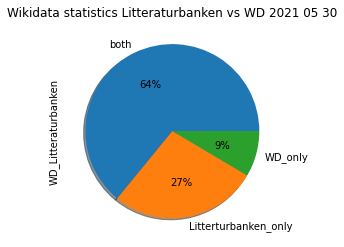

In [20]:
%matplotlib inline 
import matplotlib.pyplot as plt   
mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [21]:
mergeCheckNumber

both                    2052
Litterturbanken_only     877
WD_only                  273
Name: WD_Litteraturbanken, dtype: int64

### Check diff Wikidata <-> Litteraturbanken were we have LIBRISid

In [22]:
#mergewithLibris

In [23]:
mergewithLibris = dfmerge[dfmerge["librisid"].notnull()].copy() 
#plotmerge = mergewithLibris.plot.pie( \
#                   autopct='%1.0f%%', \
#                   shadow=True, startangle=0, \
#                   title = "Wikidata statistics Litteraturbanken with LIBRIS " + start_time.strftime('%Y %m %d'))
#plotmerge.plot( kind = 'bar',subplots=True) 
#plt.title("LIBRIS ")
#plt.savefig('LitteraturbankenWDLibris.png')
#plt.show()


In [24]:
mergewithLibris.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1616 entries, 1727 to 1743
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               1354 non-null   object        
 1   authorid                 1616 non-null   object        
 2   full_name                1616 non-null   object        
 3   wd_hos_Litteraturbanken  1352 non-null   object        
 4   authorid_norm            1616 non-null   object        
 5   show                     1616 non-null   object        
 6   updated                  1616 non-null   datetime64[ns]
 7   imported                 1616 non-null   datetime64[ns]
 8   librisid                 1616 non-null   object        
 9   WD_Litteraturbanken      1616 non-null   object        
dtypes: datetime64[ns](2), object(8)
memory usage: 138.9+ KB


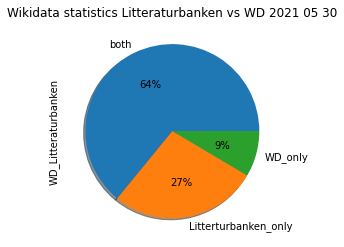

In [25]:


mergeCheckNumber = dfmerge["WD_Litteraturbanken"].value_counts()  
plotmerge = mergeCheckNumber.plot.pie( \
                   autopct='%1.0f%%', \
                   shadow=True, startangle=0, \
                   title = "Wikidata statistics Litteraturbanken vs WD " + start_time.strftime('%Y %m %d'))
plt.savefig('LitteraturbankenWD.png')
plt.show()


In [26]:
mergeCheckNumber

both                    2052
Litterturbanken_only     877
WD_only                  273
Name: WD_Litteraturbanken, dtype: int64

In [27]:
pd.set_option("display.max.rows", None) 
 
wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"]
# could be items with Show false at Litteraturbanken 
wdonly.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 273 entries, 0 to 2313
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               273 non-null    object        
 1   authorid                 273 non-null    object        
 2   full_name                0 non-null      object        
 3   wd_hos_Litteraturbanken  0 non-null      object        
 4   authorid_norm            0 non-null      object        
 5   show                     0 non-null      object        
 6   updated                  0 non-null      datetime64[ns]
 7   imported                 0 non-null      datetime64[ns]
 8   librisid                 0 non-null      object        
 9   WD_Litteraturbanken      273 non-null    object        
dtypes: datetime64[ns](2), object(8)
memory usage: 23.5+ KB


In [28]:
LitteraturbankenTotShow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2929 entries, 0 to 2928
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   full_name                2929 non-null   object        
 1   authorid                 2929 non-null   object        
 2   wd_hos_Litteraturbanken  2062 non-null   object        
 3   authorid_norm            2929 non-null   object        
 4   show                     2929 non-null   bool          
 5   updated                  2484 non-null   datetime64[ns]
 6   imported                 2484 non-null   datetime64[ns]
 7   librisid                 1616 non-null   object        
dtypes: bool(1), datetime64[ns](2), object(5)
memory usage: 163.2+ KB


In [29]:
wdonly_norm = pd.merge(wdonly, LitteraturbankenTotShow,how='outer', left_on='authorid', right_on='authorid_norm',indicator=True)
wdonly_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3195 entries, 0 to 3194
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   WikidataID                 273 non-null    object        
 1   authorid_x                 273 non-null    object        
 2   full_name_x                0 non-null      object        
 3   wd_hos_Litteraturbanken_x  0 non-null      object        
 4   authorid_norm_x            0 non-null      object        
 5   show_x                     0 non-null      object        
 6   updated_x                  0 non-null      datetime64[ns]
 7   imported_x                 0 non-null      datetime64[ns]
 8   librisid_x                 0 non-null      object        
 9   WD_Litteraturbanken        273 non-null    object        
 10  full_name_y                2929 non-null   object        
 11  authorid_y                 2929 non-null   object        
 12  wd_hos

In [30]:
#df[df['authorid_norm'].str.contains("WahlinK")] 
#df[df['authorid'].str.contains("SjödinS")] 

In [31]:
#df[df['authorid'].str.contains("SimonsenM")] 

In [32]:
# has other_name = Malan Simonsen --> SimonsenM redirect to MarnersdóttirM
#df[df['authorid'].str.contains("MarnersdóttirM")] 
df[df['authorid'].str.contains("AdlersparreCA")] 


,authorid,authorid_norm,birth,db_checksum,db_timestamp,death,doc_type,full_name,gender,imported,intro,librisid,name_for_index,pictureinfo,searchable,show,surname,updated,wikidata,db_timestamp_updated,intro_text,popularity,dramawebben,pseudonym,sources,other_name,intro_author,intro_author_norm,picture,bibliography,external_ref,presentation,seemore
12,AdlersparreCA,AdlersparreCA,{'plain': '1810'},ee8800f1bf02a701963b901a12e726c0,1620034936923,"{'date': '1862', 'plain': '1862'}",author,Carl August Adlersparre,male,2021-03-01,None,sq4677hb49x6bfd,"Adlersparre, Carl August",None,True,True,Adlersparre,2021-03-01,"{'birthplace': [14.1166, 59.3106], 'birthplace...",1.620035e+12,NaN,167.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1. merge wdonly authorid on authorid_norm --> we get the authorid that we should use 
1. next step is create Quickstatement  for delete and upload the new one see example [Calc](https://docs.google.com/spreadsheets/d/1lw1wqTmFndxlltJHhyEyzQxoGTph6J2tdVCwgmJFHdI/edit?usp=sharing)


In [33]:
wdonlymerge = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid',right_on='authorid_norm')
wdonlymerge[{'WikidataID','authorid_x','authorid_y','show_y'}] 


,show_y,authorid_x,WikidataID,authorid_y
0,True,AkerhielmG,Q52964,ÅkerhielmG
1,True,BjorklundJ,Q105742933,BjörklundJ
2,True,BorjessonL,Q105730977,BörjessonL
3,True,ClaessonD,Q105730984,ClaéssonD
4,True,OhlinCG,Q105729530,ÖhlinCG
5,True,SandstromerC,Q105729455,SandströmerC
6,True,TidstromK,Q105727505,TidströmK


In [34]:
from IPython.display import HTML
wddelete = wdonly = dfmerge[dfmerge["WD_Litteraturbanken"]=="WD_only"].copy()  
wddelete["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + wddelete["authorid"] + "'>link</a>"
pd.set_option("display.max.columns", None) 
HTML(wddelete[{"Littbank","WikidataID","authorid"}].to_html(escape=False))

,authorid,WikidataID,Littbank
0,336,Q105674275,link
17,AfzeliusO,Q15634724,link
36,AkerhielmG,Q52964,link
38,AlbertiS,Q4934765,link
42,AldénGA,Q5545821,link
46,AlighieriD,Q1067,link
48,AllardtA,Q5393031,link
53,AlmquistS,Q5547566,link
68,AnckerS,Q52714152,link
70,AnderbergB,Q4585247,link


In [35]:
dfmerge_authorid_norm = pd.merge(wdonly, LitteraturbankenTotShow, left_on='authorid', right_on='authorid_norm',indicator=True)

In [36]:
dfmerge_authorid_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 0 to 6
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   WikidataID                 7 non-null      object        
 1   authorid_x                 7 non-null      object        
 2   full_name_x                0 non-null      object        
 3   wd_hos_Litteraturbanken_x  0 non-null      object        
 4   authorid_norm_x            0 non-null      object        
 5   show_x                     0 non-null      object        
 6   updated_x                  0 non-null      datetime64[ns]
 7   imported_x                 0 non-null      datetime64[ns]
 8   librisid_x                 0 non-null      object        
 9   WD_Litteraturbanken        7 non-null      object        
 10  Littbank                   7 non-null      object        
 11  full_name_y                7 non-null      object        
 12  authorid_y  

In [37]:
dfmerge_authorid_norm.head()

,WikidataID,authorid_x,full_name_x,wd_hos_Litteraturbanken_x,authorid_norm_x,show_x,updated_x,imported_x,librisid_x,WD_Litteraturbanken,Littbank,full_name_y,authorid_y,wd_hos_Litteraturbanken_y,authorid_norm_y,show_y,updated_y,imported_y,librisid_y,_merge
0,Q52964,AkerhielmG,NaN,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,Gustaf Åkerhielm,ÅkerhielmG,Q52964,AkerhielmG,True,2021-03-01,2021-03-01,jgvz21t24rs6ggr,both
1,Q105742933,BjorklundJ,NaN,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,J. Björklund,BjörklundJ,Q105742933,BjorklundJ,True,2017-04-12,2017-04-12,NaN,both
2,Q105730977,BorjessonL,NaN,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,Lars Börjesson,BörjessonL,Q105730977,BorjessonL,True,2015-03-23,2015-03-23,NaN,both
3,Q105730984,ClaessonD,NaN,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,Dick Claésson,ClaéssonD,Q105730984,ClaessonD,True,2020-03-30,2015-09-30,NaN,both
4,Q105729530,OhlinCG,NaN,NaN,NaN,NaN,NaT,NaT,NaN,WD_only,<a href='https://litteraturbanken.se/f%C3%B6rf...,Carl Gustaf Öhlin,ÖhlinCG,Q105729530,OhlinCG,True,2021-03-01,2021-03-01,tr58ddfc2bb84f2,both


In [38]:
#dfmerge_authorid_norm[{'WikidataID','authorid_x','authorid_y'}] 

### Check items not matched to Wikidata but has Librisid

In [39]:
dfmerge["WD_Litteraturbanken"].value_counts()  

both                    2052
Litterturbanken_only     877
WD_only                  273
Name: WD_Litteraturbanken, dtype: int64

In [40]:
Litterturbanken_only = dfmerge[dfmerge["WD_Litteraturbanken"]=="Litterturbanken_only"]  
Litterturbanken_only.info()
#Litterturbanken_only.head(50)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877 entries, 2960 to 3201
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               0 non-null      object        
 1   authorid                 877 non-null    object        
 2   full_name                877 non-null    object        
 3   wd_hos_Litteraturbanken  18 non-null     object        
 4   authorid_norm            877 non-null    object        
 5   show                     877 non-null    object        
 6   updated                  638 non-null    datetime64[ns]
 7   imported                 638 non-null    datetime64[ns]
 8   librisid                 262 non-null    object        
 9   WD_Litteraturbanken      877 non-null    object        
dtypes: datetime64[ns](2), object(8)
memory usage: 75.4+ KB


In [41]:
Litterturbanken_only.to_csv("LitteraturbankenAuthor_new.csv")
# LitteraturbankenAuthor_new.csv

In [42]:
#Litterturbanken_only

* See latest checked [LitteraturbankenAuthor_new.csv in GITHUB](https://github.com/salgo60/open-data-examples/blob/master/LitteraturbankenAuthor_new)

In [43]:
#Get all items with no Wikidata item but has librisid --> can match them using Open Refine 
Litterturbanken_only[Litterturbanken_only['librisid'].notnull()].count()

WikidataID                   0
authorid                   262
full_name                  262
wd_hos_Litteraturbanken      3
authorid_norm              262
show                       262
updated                    262
imported                   262
librisid                   262
WD_Litteraturbanken        262
dtype: int64

## Errors funna nedan 
* Show True borde det inte vara False?: Eugénie BerglindhU EngeströmL Rafael WestinF 
* Dublett: NordinCG / NordinC , ArfvidssonN / ArfwidssonN 
* [SimonsenM](https://litteraturbanken.se/f%C3%B6rfattare/SimonsenM) är lite udda med en se [Malan Marnersdóttir](https://litteraturbanken.se/f%C3%B6rfattare/Marnersd%C3%B3ttirM/titlar) 
  * undran hur ser jag det i datat
  
Skapar en task på GITHUB         
* ~~[feedback data 24](https://github.com/spraakbanken/littb-frontend/issues/24)~~


In [44]:
#Litterturbanken_only.head()

In [45]:
Litterturbanken_onlyW = Litterturbanken_only[Litterturbanken_only['librisid'].notnull()][{'full_name','WikidataID','authorid','WD_Litteraturbanken','librisid','show'}].copy() 
Litterturbanken_onlyW["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + Litterturbanken_only["authorid"] + "'>link Litteraturbanken</a>"
Litterturbanken_onlyW["LittbankJSON"] = "<a href='https://litteraturbanken.se/api/get_author/" + Litterturbanken_only["authorid"] + "'>json</a>"
HTML(Litterturbanken_onlyW.to_html(escape=False))


,authorid,librisid,full_name,WD_Litteraturbanken,WikidataID,show,Littbank,LittbankJSON
2960,AhlinL,tr5788hc45t7jzw,Lars Ahlin,Litterturbanken_only,NaN,True,link Litteraturbanken,json
2330,LundgrenNA,wt79cd2f4lbrmd9,Nils August Lundgren,Litterturbanken_only,NaN,True,link Litteraturbanken,json
2332,LundgrenA,b8nrvx9v0xkl70m,Alfred Lundgren,Litterturbanken_only,NaN,True,link Litteraturbanken,json
2333,EkerotHj,qzmrfjllnbhpd6m8,Hjalmar Ekerot,Litterturbanken_only,NaN,True,link Litteraturbanken,json
2334,SanderNF,nl025vz64m15297,Nils Fredrik Sander,Litterturbanken_only,NaN,True,link Litteraturbanken,json
2326,ReuterOM,tr57b0nc5hzl7v1,Odo Morannal Reuter,Litterturbanken_only,NaN,True,link Litteraturbanken,json
2339,BerglundEW,pm1489v727hdmjd,Erik Wilhelm Berglund,Litterturbanken_only,NaN,True,link Litteraturbanken,json
2340,HectorD,qn2463c83hxf2rh,David Hector,Litterturbanken_only,NaN,True,link Litteraturbanken,json
2342,MartinelleA,wt79dqff15cbsfk,Algot Martinelle,Litterturbanken_only,NaN,True,link Litteraturbanken,json
2344,UlinU,khw03tn31rss3mr,U. Ulin,Litterturbanken_only,NaN,True,link Litteraturbanken,json


In [46]:
#df[df['authorid_norm'].str.contains("ArfvidssonN")] 

In [47]:
#df[df['authorid_norm'].str.contains("ArfwidssonN")] 

### Find objects with Show false at Litteraturbanken 
If found in Wikidata they are candidates to be deleted in Wikidata 

* Looks like we have some oddities in the Litteraturbanken data as items with Show False looks ok to use see [tweet](https://twitter.com/salgo60/status/1313834219794296834?s=20)

In [48]:
LitteraturbankenTotNotShow = LitteraturbankenTot[LitteraturbankenTot["show"]==False]  
dfmergeDelete = pd.merge(WDLittbanktot, LitteraturbankenTotNotShow,how='outer', on='authorid',indicator=True)

In [49]:
# both are candidates to be deleted as they have show False
dfmergeDelete["_merge"].value_counts()  

left_only     2071
right_only     745
both           254
Name: _merge, dtype: int64

In [50]:
dfmergeDeleteBoth = dfmergeDelete[dfmergeDelete["_merge"]=="both"].copy() 
del dfmergeDeleteBoth['_merge']
dfmergeDeleteBoth["Littbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + dfmergeDeleteBoth["authorid"] + "'>link Litteraturbanken</a>"
dfmergeDeleteBoth["LittbankJSON"] = "<a href='https://litteraturbanken.se/api/get_author/" + dfmergeDeleteBoth["authorid"] + "'>json</a>"
dfmergeDeleteBoth["Wikidata"] = "<a href='https://www.wikidata.org/wiki/" + dfmergeDeleteBoth["WikidataID"] + "'>WD</a>"
HTML(dfmergeDeleteBoth.to_html(escape=False))
# list ok but has Show False

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata
17,Q15634724,AfzeliusO,Oriel Otto Afzelius,Q15634724,AfzeliusO,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD
38,Q4934765,AlbertiS,Sophie Alberti,Q4934765,AlbertiS,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD
42,Q5545821,AldénGA,Gustaf Alfred Aldén,Q5545821,AldenGA,False,2022-02-22,2022-02-22,sq47b5xb3nptlnd,link Litteraturbanken,json,WD
46,Q1067,AlighieriD,Dante Alighieri,Q1067,AlighieriD,False,2019-10-16,2014-02-11,c9prrn7w4mx98hn,link Litteraturbanken,json,WD
48,Q5393031,AllardtA,Anders Allardt,Q5393031,AllardtA,False,2022-02-22,2022-02-22,nl0235k6095bxbb,link Litteraturbanken,json,WD
53,Q5547566,AlmquistS,Sigfrid Almquist,Q5547566,AlmquistS,False,2019-10-16,2014-02-11,tr57bgqc00sszjd,link Litteraturbanken,json,WD
68,Q52714152,AnckerS,Stina Ancker,Q52714152,AnckerS,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD
70,Q4585247,AnderbergB,Bengt Anderberg,Q4585247,AnderbergB,False,2019-10-16,2010-09-20,qn244rz85nr8054,link Litteraturbanken,json,WD
75,Q5593713,AndersonW,William Anderson,Q5593713,AndersonW,False,2022-02-22,2022-02-22,tr58dfcc2f7m50m,link Litteraturbanken,json,WD
86,Q4935813,AnderssonI,Ingrid Andersson,Q4935813,AnderssonI,False,2019-10-16,2014-02-11,vs689zpd2hs6914,link Litteraturbanken,json,WD


In [51]:
dfmergeDeleteBoth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 17 to 2313
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   WikidataID               254 non-null    object        
 1   authorid                 254 non-null    object        
 2   full_name                254 non-null    object        
 3   wd_hos_Litteraturbanken  241 non-null    object        
 4   authorid_norm            254 non-null    object        
 5   show                     254 non-null    object        
 6   updated                  231 non-null    datetime64[ns]
 7   imported                 231 non-null    datetime64[ns]
 8   librisid                 160 non-null    object        
 9   Littbank                 254 non-null    object        
 10  LittbankJSON             254 non-null    object        
 11  Wikidata                 254 non-null    object        
dtypes: datetime64[ns](2), object(10)
m

In [52]:
#List I think shouldnt have Show False in LItteraturbanken

ErrorShowFalseLitteraturbank = pd.DataFrame(['BirchPfeifferC','BjörkmanE','ButenschönA','RomanusAlfvénAC','SjödinS',
                                    'TirénG','ÅströmP','AndrénV','DobbinL','HallbergP','JonssonErnst',
                                    'WästbergA','LundströmM','WästbergA','NordlingS','BerggrenH','AustenJ',
                                             'BjörnbergE'
                                             
                                            ],columns =['authorid'])
# Get list without errors
dfmergeDeleteCorrected = pd.merge(dfmergeDeleteBoth, ErrorShowFalseLitteraturbank,how='outer', on='authorid',indicator=True)
#HTML(dfmergeDeleteCorrected.to_html(escape=False))


## Problem records that has show false

In [53]:
ErrorShowFalseLitteraturbank["Litteraturbank"] = "<a href='https://litteraturbanken.se/f%C3%B6rfattare/" + ErrorShowFalseLitteraturbank["authorid"] + "'>link</a>"
ErrorShowFalseLitteraturbank["get_author"] = "<a href='https://litteraturbanken.se/api/get_author/" + ErrorShowFalseLitteraturbank["authorid"] + "'>get_author</a>"

ErrorShowFalseLitteraturbank.sort_values(by=['authorid'],inplace=True, ascending=[True])
HTML(ErrorShowFalseLitteraturbank.to_html(escape=False))


,authorid,Litteraturbank,get_author
7,AndrénV,link,get_author
16,AustenJ,link,get_author
15,BerggrenH,link,get_author
0,BirchPfeifferC,link,get_author
1,BjörkmanE,link,get_author
17,BjörnbergE,link,get_author
2,ButenschönA,link,get_author
8,DobbinL,link,get_author
9,HallbergP,link,get_author
10,JonssonErnst,link,get_author


## List to check
Indicates 
1. if we have objects with Show False in WIkidata or
1. Litteraturbanken has objects with books but has Show False

see also ErrorShowFalseLitteraturbank

**Lessom learned** we have bots that update from Litteraturbanken that sometimes add a mess....

In [54]:
# Should be empty else delete in Wikidata or add to ErrorShowFalseLitteraturbank
HTML(dfmergeDeleteCorrected[dfmergeDeleteCorrected["_merge"]=="left_only"].to_html(escape=False))

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata,_merge
0,Q15634724,AfzeliusO,Oriel Otto Afzelius,Q15634724,AfzeliusO,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD,left_only
1,Q4934765,AlbertiS,Sophie Alberti,Q4934765,AlbertiS,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD,left_only
2,Q5545821,AldénGA,Gustaf Alfred Aldén,Q5545821,AldenGA,False,2022-02-22,2022-02-22,sq47b5xb3nptlnd,link Litteraturbanken,json,WD,left_only
3,Q1067,AlighieriD,Dante Alighieri,Q1067,AlighieriD,False,2019-10-16,2014-02-11,c9prrn7w4mx98hn,link Litteraturbanken,json,WD,left_only
4,Q5393031,AllardtA,Anders Allardt,Q5393031,AllardtA,False,2022-02-22,2022-02-22,nl0235k6095bxbb,link Litteraturbanken,json,WD,left_only
5,Q5547566,AlmquistS,Sigfrid Almquist,Q5547566,AlmquistS,False,2019-10-16,2014-02-11,tr57bgqc00sszjd,link Litteraturbanken,json,WD,left_only
6,Q52714152,AnckerS,Stina Ancker,Q52714152,AnckerS,False,2014-03-07,2014-02-11,NaN,link Litteraturbanken,json,WD,left_only
7,Q4585247,AnderbergB,Bengt Anderberg,Q4585247,AnderbergB,False,2019-10-16,2010-09-20,qn244rz85nr8054,link Litteraturbanken,json,WD,left_only
8,Q5593713,AndersonW,William Anderson,Q5593713,AndersonW,False,2022-02-22,2022-02-22,tr58dfcc2f7m50m,link Litteraturbanken,json,WD,left_only
9,Q4935813,AnderssonI,Ingrid Andersson,Q4935813,AnderssonI,False,2019-10-16,2014-02-11,vs689zpd2hs6914,link Litteraturbanken,json,WD,left_only


In [55]:
# Indicates that trhis member shouldnt be dfmergeDeleteCorrected
HTML(dfmergeDeleteCorrected[dfmergeDeleteCorrected["_merge"]=="right_only"].to_html(escape=False))

,WikidataID,authorid,full_name,wd_hos_Litteraturbanken,authorid_norm,show,updated,imported,librisid,Littbank,LittbankJSON,Wikidata,_merge
254,NaN,AndrénV,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,right_only
255,NaN,WästbergA,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,right_only
256,NaN,WästbergA,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,right_only
257,NaN,LundströmM,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,right_only


In [56]:
end = datetime.now()
print("Ended: ", end) 
print('Time elapsed (hh:mm:ass.ms) {}'.format(datetime.now() - start_time))

Ended:  2021-05-30 14:27:15.767443
Time elapsed (hh:mm:ass.ms) 0:00:06.637842
